# Fetching simple lepton data

This demo uses ServiceX to fetch electron data from an ATLAS Z->ee and an Z->$\mu\mu$ xAOD dataset.

## Setup

This demo requires a version of `servicex` up and running, as well as two ports forwarded for the service. As of this release, this requires that the pods `servicex-app` and `minio` be forwarded using the command `port-forward `on ports 5000 and 9000 respectively from the `k8` cluster hosting the service.

In [1]:
from servicex import ServiceXDataset
from servicex.minio_adaptor import MinioAdaptor
from servicex.servicex_adaptor import ServiceXAdaptor
from func_adl import EventDataset
from func_adl_xAOD import ServiceXDatasetSource


import uproot_methods
import matplotlib.pyplot as plt

import datetime

Here, we decide which datasets we're interested in. We have also set up our endpoints and credentials to be able to use the public instance of ServiceX on RIVER, using the ServiceX Adaptor and the Minio Adaptor objects.

In [2]:
adaptor = ServiceXAdaptor(endpoint = 'localhost:5000/servicex', username = 'INSERT_YOUR_USERNAME_HERE', password = 'INSERT_YOUR_PASSWORD_HERE')
minio_adaptor = MinioAdaptor(mino_endpoint = 'localhost:9000', access_key = 'miniouser', secretkey = 'leftfoot1')

def create_dataset(dataset_name):
    sxdataset = ServiceXDataset(
    dataset_name,
    servicex_adaptor = adaptor,
    minio_adaptor = minio_adaptor)
    
    return sxdataset
    
zee_dataset = create_dataset('mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00')
zmm_dataset = create_dataset('mc15_13TeV:mc15_13TeV.361107.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zmumu.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630078_00')

### Function definitions

In [3]:
def retrieve_data(dataset):
    data = ServiceXDatasetSource(dataset) \
    .Select('lambda e: (e.Electrons("Electrons"), e.Muons("Muons"))') \
    .Select('lambda ls: (ls[0].Select(lambda e: e.pt()), ls[0].Select(lambda e: e.eta()), \
                         ls[0].Select(lambda e: e.phi()), ls[0].Select(lambda e: e.e()), \
                         ls[1].Select(lambda m: m.pt()), ls[1].Select(lambda m: m.eta()), \
                         ls[1].Select(lambda m: m.phi()), ls[1].Select(lambda m: m.e()))') \
    .AsAwkwardArray(('ElePt', 'EleEta', 'ElePhi', 'EleE', 'MuPt', 'MuEta', 'MuPhi', 'MuE')) \
    .value()
    return data

def four_vectorize(leptons_per_event, lepton_type):
    four_vector = uproot_methods.TLorentzVectorArray.from_ptetaphi(
    leptons_per_event[bytes(f"{lepton_type}Pt", 'utf-8')], leptons_per_event[bytes(f"{lepton_type}Eta", 'utf-8')],
    leptons_per_event[bytes(f"{lepton_type}Phi", 'utf-8')], leptons_per_event[bytes(f"{lepton_type}E", 'utf-8')],
    )
    
    return four_vector

def organize_leptons(dataset, lepton_type):
    v_leptons = four_vectorize(dataset, lepton_type)
    v_leptons = v_leptons[v_leptons.counts >= 2]
    dileptons = v_leptons[:, 0] + v_leptons[:, 1]
    
    return dileptons

def plot_data(dielectrons, dimuons):
    plt.figure(figsize=(12, 6))
    plt.hist(dielectrons.mass/1000.0, bins=100, range=(0,200))
    plt.title('Di-Electron Mass')
    plt.xlabel('$m_{ee}$ [GeV]')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(12,6))
    plt.hist(dimuons.mass/1000.0, bins=100, range=(0,200))
    plt.title('Di-Muon Mass')
    plt.xlabel('$m_{\mu\mu}$ [GeV]')
    plt.ylabel('Count')
    plt.show()

At this point, we are ready to ask ServiceX to fetch our data.

In [4]:
zee_retrieved_data = retrieve_data(zee_dataset)
zmm_retrieved_data = retrieve_data(zmm_dataset)

After this, we are interested in plotting the muon and electron counts for the `z->ee` dataset. We analyze the raw datasets and convert the information to the counts, and then we plot the data.

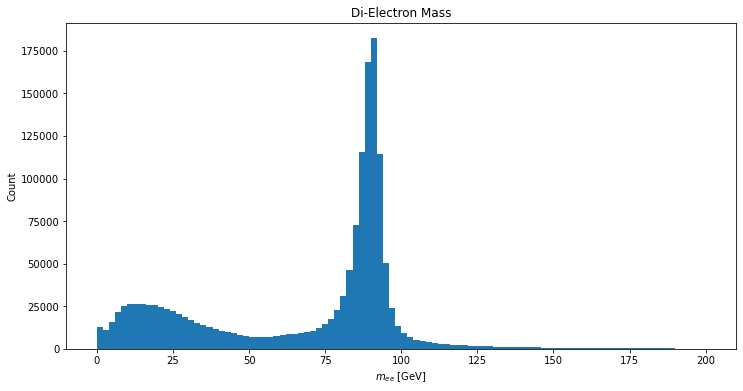

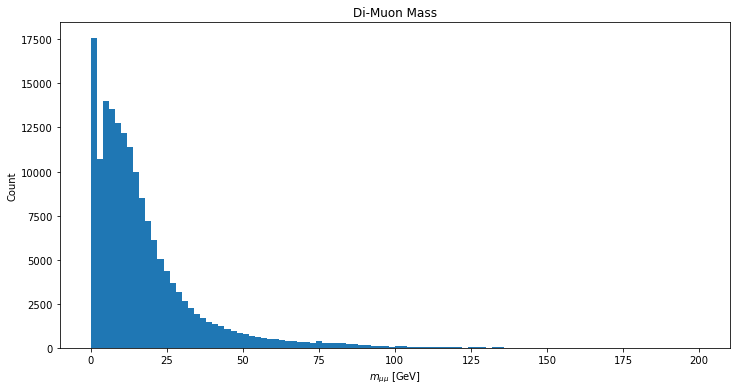

In [5]:
zee_die = organize_leptons(zee_retrieved_data, 'Ele')
zee_dim = organize_leptons(zee_retrieved_data, 'Mu')

plot_data(zee_die, zee_dim)

Finally, we do the same as above for the z->$\mu\mu$ dataset. As expected, the shapes switch and we find a exponentially decaying count for the electrons, but a peak for the muons.

f:\program files (x86)\python 3.7\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
f:\program files (x86)\python 3.7\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


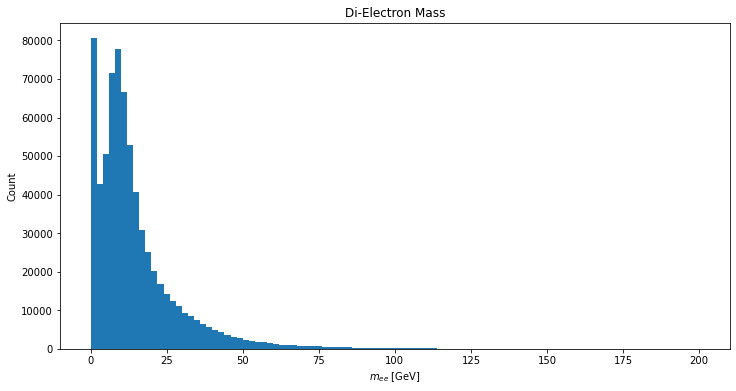

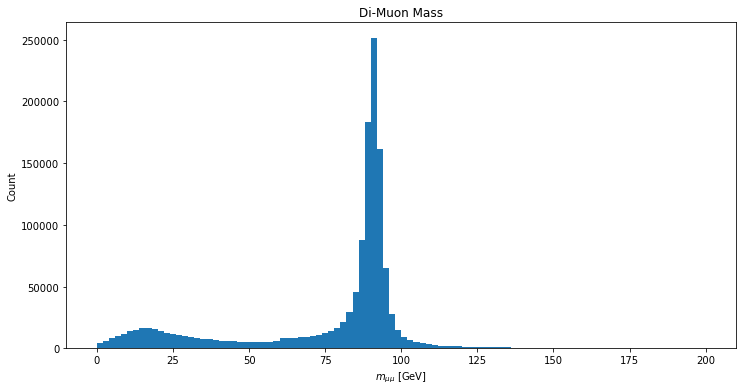

In [6]:
zmm_die = organize_leptons(zmm_retrieved_data, 'Ele')
zmm_dim = organize_leptons(zmm_retrieved_data, 'Mu')

plot_data(zmm_die, zmm_dim)